## We choose a window of 60 time steps
## We want to learn 59 steps and predict 1 steps.
## Each step = 1 second

In [49]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


pos.x     pos.y     pos.z   heading  velocity  weather
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2

In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

pos.x     pos.y     pos.z   heading  velocity  weather    Minute sin  \
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2 -1.792514e-08   
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2  1.045284e-01   
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2  2.079117e-01   
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2  3.090170e-01   
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2  4.067366e-01   

   Minute cos  
0    1.000000  
1    0.994522  
2    0.978148  
3    0.951057  
4    0.913545

### Windowing
We choose a window of 60 time steps
We want to learn 59 steps and predict 1 steps.

In [9]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76620
60
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((61296, 60, 8), (15324, 60, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence(x_train_init)

In [14]:
x_train.shape, y_train.shape

((61296, 59, 8), (61296, 1, 8))

In [15]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [16]:
y_train.shape

(61296, 1, 2)

In [17]:
y_train = y_train.reshape((-1, y_train.shape[-1]))

In [18]:
y_train.shape

(61296, 2)

In [19]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence(x_test_init)

In [20]:
x_test.shape, y_test.shape

((15324, 59, 8), (15324, 1, 8))

In [21]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [22]:
y_test.shape

(15324, 1, 2)

In [23]:
y_test = y_test.reshape((-1, y_test.shape[-1]))

In [24]:
y_test.shape

(15324, 2)

### Model Configuration

In [25]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(59, 8)

In [26]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2,)

In [27]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 1
output_features_nr=y_train_feature_nr * output_seq_size
output_features_nr

2

### Train and evaluate

In [28]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [29]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_nr, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [31]:
epochs = 5
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
1533/1533 [==============================] - 135s 86ms/step - loss: 408.6631 - mae: 14.2559 - val_loss: 215.0489 - val_mae: 9.0331 - lr: 0.0010
Epoch 2/5
1533/1533 [==============================] - 130s 85ms/step - loss: 407.5318 - mae: 14.1967 - val_loss: 213.7113 - val_mae: 9.1598 - lr: 0.0010
Epoch 3/5
1533/1533 [==============================] - 130s 85ms/step - loss: 398.7934 - mae: 14.0952 - val_loss: 225.4005 - val_mae: 9.6735 - lr: 0.0010
Epoch 4/5
1533/1533 [==============================] - 145s 94ms/step - loss: 387.9624 - mae: 13.9266 - val_loss: 218.3513 - val_mae: 9.1344 - lr: 0.0010
Epoch 5/5
1533/1533 [==============================] - 151s 99ms/step - loss: 380.1573 - mae: 13.7564 - val_loss: 210.8819 - val_mae: 9.2119 - lr: 0.0010


In [ ]:
#model.summary()

In [32]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

479/479 [==============================] - 14s 28ms/step - loss: 190.3986 - mae: 8.7811
Test accuracy 8.7811279296875
Test loss 190.39859008789062


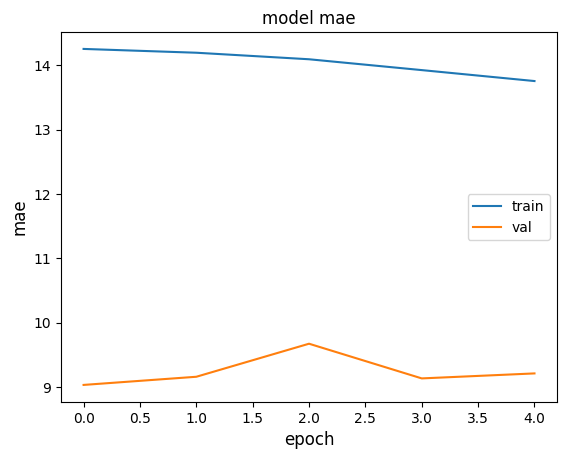

In [33]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [34]:
predictions = model.predict(x_test)

479/479 [==============================] - 14s 28ms/step


In [35]:
predictions.shape

(15324, 2)

Visualize some few predictions


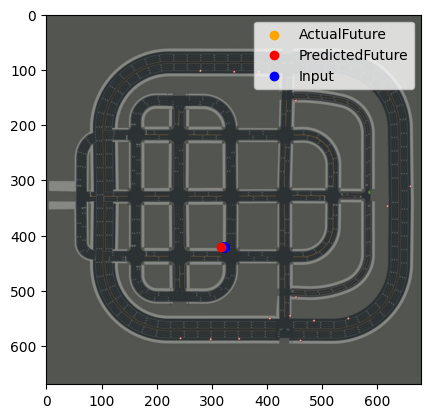

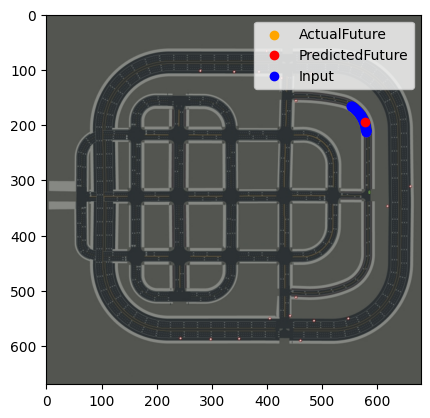

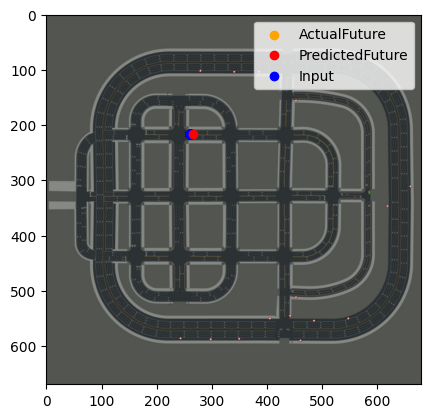

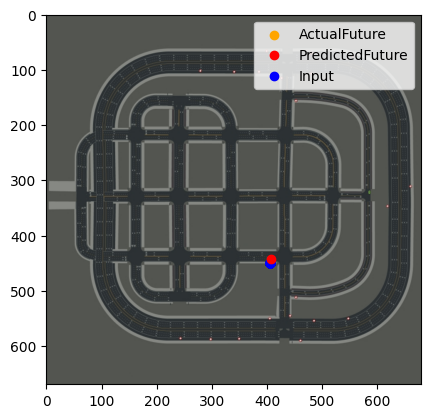

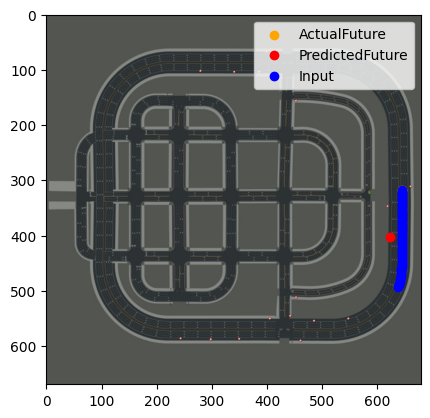

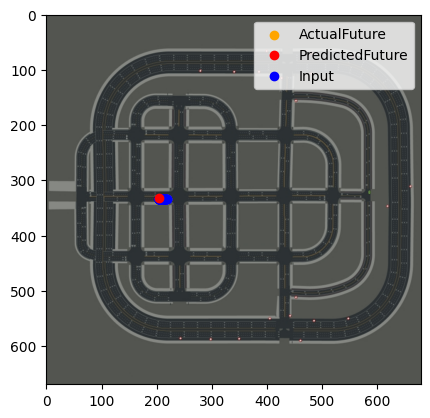

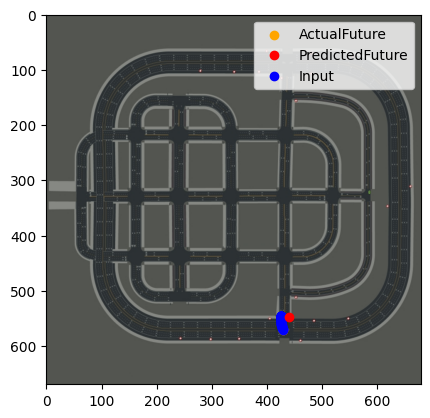

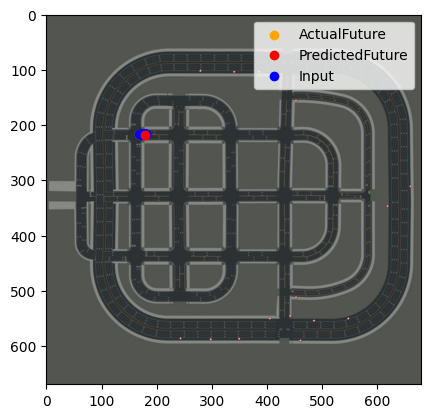

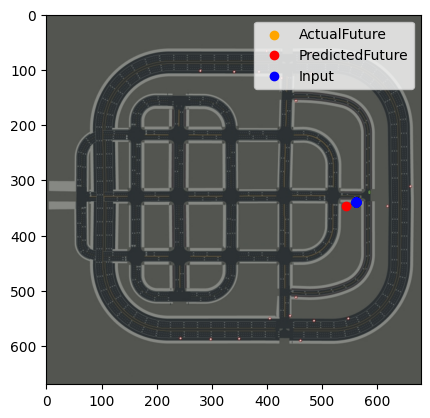

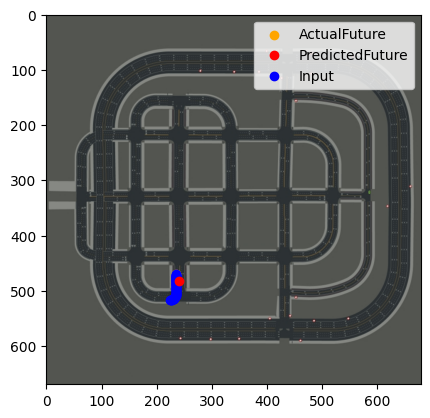

In [36]:
import random
from configs.utils_2 import plot_pred


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test))
        plot_pred(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

In [51]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model, isMultivariate=True)
explainer = ITPFExplainer()
explainer.fit_exp(
    model=blackbox, 
    x=x_train, y=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], 
    class_names=['pos.x', 'pos.y'], 
    feature_nr=8, 
    feature_pred_nr=2
)

In [38]:
y=x_test[0]

### LIME

In [39]:
explainer.lime(y=y, labelId=0)

(5000, 59, 8)
157/157 [==============================] - 4s 28ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


In [40]:
explainer.lime(y=y, labelId=1)

(5000, 59, 8)
157/157 [==============================] - 5s 29ms/step



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


### Shap

In [41]:
y.shape

(59, 8)

2/2 [==============================] - 0s 11ms/step


  0%|          | 0/59 [00:00<?, ?it/s]

233/233 [==============================] - 1s 5ms/step


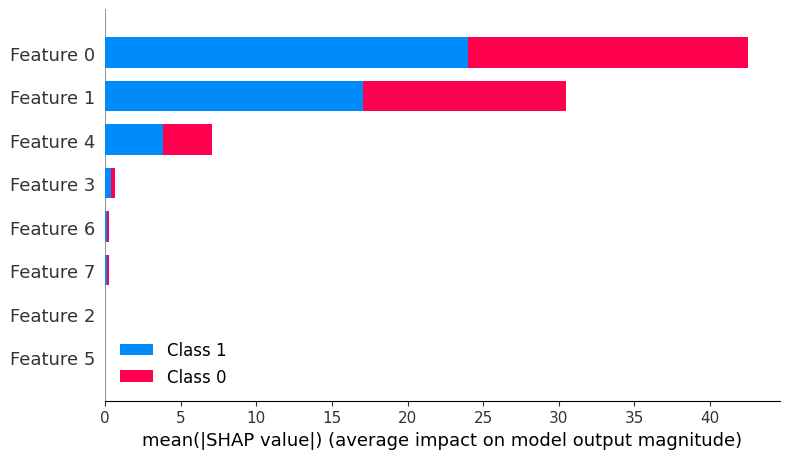

In [46]:
explainer.shap(y)

### Shap Multivariate

In [52]:
shap_values = explainer.shap_values_multivariate(y)

(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 14ms/step
(1, 59, 8)
1/1 [==============================] - 0s 17ms/step
(1, 59, 8)
1/1 [==============================] - 0s 17ms/step
(1, 59, 8)
1/1 [==============================] - 0s 20ms/step
(1, 59, 8)
1/1 [==============================] - 0s 15

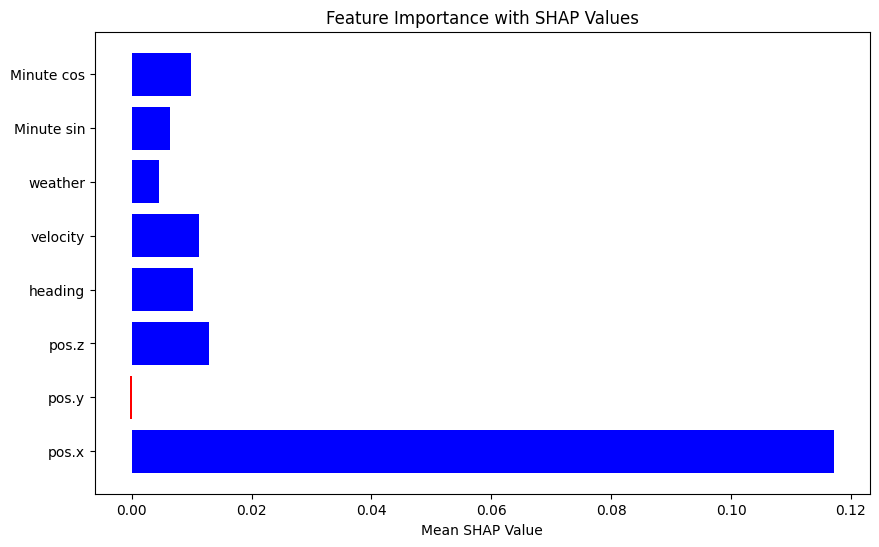

In [53]:
explainer.shap_multivariate(shap_values, 0)

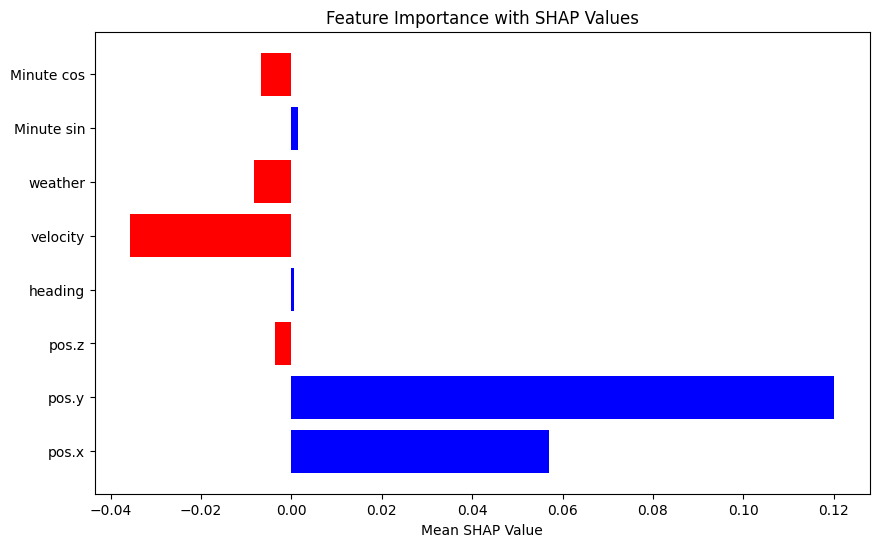

In [54]:
explainer.shap_multivariate(shap_values, 1)